<a href="https://colab.research.google.com/github/yasirabd/research-diagnostic-turbine/blob/main/Diagnostics_Turbine_Bearing_1_Cooling_Loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Create: 23 Desember 2021*<br>
*Last Update: 3 January 2022*<br>
*Author: Yasir Abdur Rohman*<br>
**Property of PT Indonesia Power & Lab Getaran & Diagnosis Mesin Undip**

---

## Problem Description

**Case:** ST Journal Bearing 1 - Cooling Loss

**Description:**

This fault indicates an abnormal change in the cooling of the supply oil to the bearings.  

Primary indicators are: 
- Journal Bearing Oil Outlet Temperature (Oil Return) is high; 
- and Bearing Metal Temperature is high.   

and 
- Priority 4 (lowest) is triggered when either Lube Oil Outlet Temperature is high or 
- Bearing Metal Temperature is high.  

The priority escalates depending on the severity of the change, and the number of sensors.  This fault triggers  Priority 2, 3 & 4.

**Input Tags:**
- LUBE_OIL_COOLER_OIL_OUTLET_TEMP
- GROSS_LOAD
- LUBE_OIL_COOLER_OIL_OUTLET_PRESS
- BRG_1_MTL_TEMP_1 
- AMBIENT_TEMP
- BRG_1_MTL_TEMP_2 
- BRG_1_MTL_TEMP_4 
- BRG_1_MTL_TEMP_3
- BRG_1_OIL_DRAIN_TEMP

**Expressions:**

```
if
    (ModelIndications(MECHANICAL,[SVH,SH,VH],[BRG_1_OIL_DRAIN_TEMP])>=1.0
    and
    ModelIndications(MECHANICAL,[SVH,SH,VH],[BRG_1_MTL_TEMP_1, BRG_1_MTL_TEMP_2, BRG_1_MTL_TEMP_3, BRG_1_MTL_TEMP_4])>=1.0)
then 
    Priority(2)
else if
    (ModelIndications(MECHANICAL,[SVH,SH,VH],[BRG_1_OIL_DRAIN_TEMP])>=1.0
    or 
        (ModelIndications(MECHANICAL,[VAR,H],[BRG_1_OIL_DRAIN_TEMP])>=1.0
        and
        ModelIndications(MECHANICAL,[VAR,H],[BRG_1_MTL_TEMP_1, BRG_1_MTL_TEMP_2, BRG_1_MTL_TEMP_3, BRG_1_MTL_TEMP_4])>=1.0))
then 
    Priority(3)
else if
    (ModelIndications(MECHANICAL,[VAR,H],[BRG_1_OIL_DRAIN_TEMP])>=1.0)
then 
    Priority(4)
else
    IsAssociated(MECHANICAL,[GROSS_LOAD,AMBIENT_TEMP,LUBE_OIL_COOLER_OIL_OUTLET_TEMP, LUBE_OIL_COOLER_OIL_OUTLET_PRESS])
```

# Import Libraries

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from scipy.spatial import distance

from sklearn.metrics import mean_squared_error

# Dataset

In [10]:
path = "/content/drive/MyDrive/Prescriptive Maintenance/Data/Turbine Generator - SLA5/export_datasla5_01ags21-31okt21.csv"
data = pd.read_csv(path)
data.shape

(132479, 85)

In [11]:
# slice data
cols = ['Generator Gross Capacity',
        'Turbine Lube Oil Cooler Outlet Temperature',
        'Turbine Bearing #01 Metal Temperature',
        'Turbine.Bearing 1 Metal Temperature',
        'Turbine.Bearing Oil Pressure',
        'Turbine.Bearing 1 Drain Oil Temperature']

data = data[['date']+cols]

# sort by index
data = data.sort_values(by='date').reset_index(drop=True)

# convert date to datetime
data['date'] = pd.to_datetime(data['date'])

data.head()

,date,Generator Gross Capacity,Turbine Lube Oil Cooler Outlet Temperature,Turbine Bearing #01 Metal Temperature,Turbine.Bearing 1 Metal Temperature,Turbine.Bearing Oil Pressure,Turbine.Bearing 1 Drain Oil Temperature
0,2021-08-01 00:00:00,594.655200,46.356762,79.52576,84.711440,1.288945,51.465816
1,2021-08-01 00:01:00,587.230042,46.344955,80.16380,84.924774,1.294842,51.453390
2,2021-08-01 00:02:00,590.609131,46.331780,80.53400,84.938736,1.290403,51.440964
3,2021-08-01 00:03:00,595.542969,46.318603,80.05665,84.700806,1.292539,51.428535
4,2021-08-01 00:04:00,595.711365,46.307793,79.51846,84.569700,1.293622,51.416110


In [12]:
# handle missing with interpolation
for col in cols:
    data[col] = data[col].interpolate(method='linear')

data.isnull().sum()

date                                          0
Generator Gross Capacity                      0
Turbine Lube Oil Cooler Outlet Temperature    0
Turbine Bearing #01 Metal Temperature         0
Turbine.Bearing 1 Metal Temperature           0
Turbine.Bearing Oil Pressure                  0
Turbine.Bearing 1 Drain Oil Temperature       0
dtype: int64

In [13]:
# missing value 

# Prognostic (Estimate)

## Threshold

In [14]:
# threshold
val = [[433.969025, 610.248900],
       [41.625633, 47.335740],
       [75.298727, 92.167030],
       [80.187670, 87.590470],
       [1.467023, 1.512295],
    #    [47.408993, 56.443672]]
       [47.408993, 52]]
threshold = pd.DataFrame(val, columns=['Actual (Low)', 'Actual (High)'], index=list(data)[1:])
threshold

,Actual (Low),Actual (High)
Generator Gross Capacity,433.969025,610.248900
Turbine Lube Oil Cooler Outlet Temperature,41.625633,47.335740
Turbine Bearing #01 Metal Temperature,75.298727,92.167030
Turbine.Bearing 1 Metal Temperature,80.187670,87.590470
Turbine.Bearing Oil Pressure,1.467023,1.512295
Turbine.Bearing 1 Drain Oil Temperature,47.408993,52.000000


## Infant Model

In [15]:
# create an infant model
two_weeks = pd.to_datetime('2021-09-01 00:00:00') + pd.DateOffset(days=15)

# filter data by date
filter = (data['date'] >= '2021-09-01 00:00:00') & (data['date'] < two_weeks)
data_slice = data[filter].reset_index(drop=True)
data_slice.shape

(21600, 7)

In [16]:
# create state_matrix for an infant model
state_matrix = []
for i in range(len(data_slice)):

    temp = []
    for col in cols:
        actual = data_slice.loc[i,col]
        th_low = threshold.loc[col, 'Actual (Low)']
        th_high = threshold.loc[col, 'Actual (High)']

        if actual > th_low and actual < th_high:
            temp.append(actual)
        else:
            break

    if len(temp) == 6:
        state_matrix.append(np.array(temp))
    
    if len(state_matrix) == 400:
        state_matrix = np.array(state_matrix).T
        print(i)
        break

1450


In [17]:
state_matrix.shape

(6, 400)

## VBM

In [18]:
def scipy_distance(vector1, vector2, dist='euclidean'):
    if dist == 'euclidean':
        return distance.euclidean(vector1, vector2)
    elif dist == 'braycurtis':
        return distance.braycurtis(vector1, vector2)
    elif dist == 'correlation':
        return distance.correlation(vector1, vector2)
    elif dist == 'canberra':
        return distance.canberra(vector1, vector2)
    elif dist == 'chebyshev':
        return distance.chebyshev(vector1, vector2)
    elif dist == 'cityblock':
        return distance.cityblock(vector1, vector2)
    elif dist == 'minkowski':
        return distance.minkowski(vector1, vector2)
    elif dist == 'sqeuclidean':
        return distance.sqeuclidean(vector1, vector2)
    elif dist == 'cosine':
        return distance.cosine(vector1, vector2)

# function to create a dynamic matrix 
def create_dynamic_matrix(matrix, current_actual):
    
    # get current actual
    # current_actual = matrix[:, -1]

    # calculate similarity
    sim_vec = []
    for i in range(matrix.shape[1]):
        sim = 1 - scipy_distance(current_actual, matrix[:, i], dist='canberra')
        sim_vec.append(sim)
    
    # sort the matrix
    n = 10
    top = np.sort(np.array(sim_vec).argsort()[::-1][:n])
    top_sim_vec = np.array(sim_vec)[top]

    # create dynamic matrix
    dynamic_matrix = matrix[:, top]

    # calculate weight
    weight = np.array([s/np.sum(top_sim_vec) for s in top_sim_vec])

    return dynamic_matrix, weight

def vbm(dynamic_matrix, weight):
    return np.dot(dynamic_matrix, weight.T)

# Diagnostic

## Analytic Tag Attributes

https://www.ge.com/digital/documentation/predix-apm/latest/smartsignal-expression-syntax.html

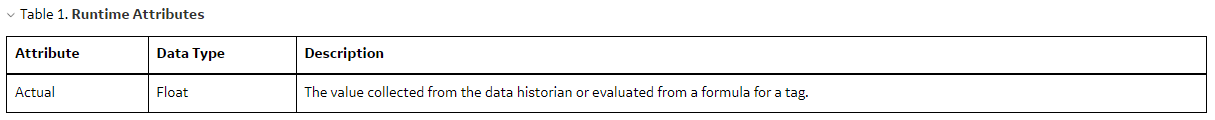

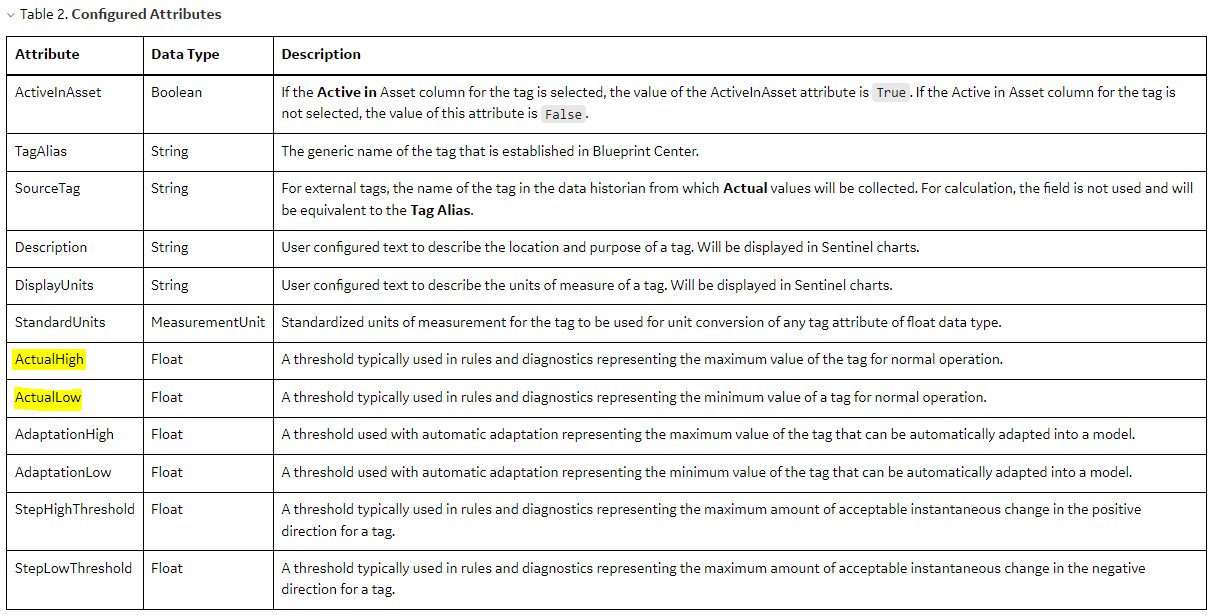

## Model Tag Attributes

https://www.ge.com/digital/documentation/predix-apm/latest/smartsignal-expression-syntax.html

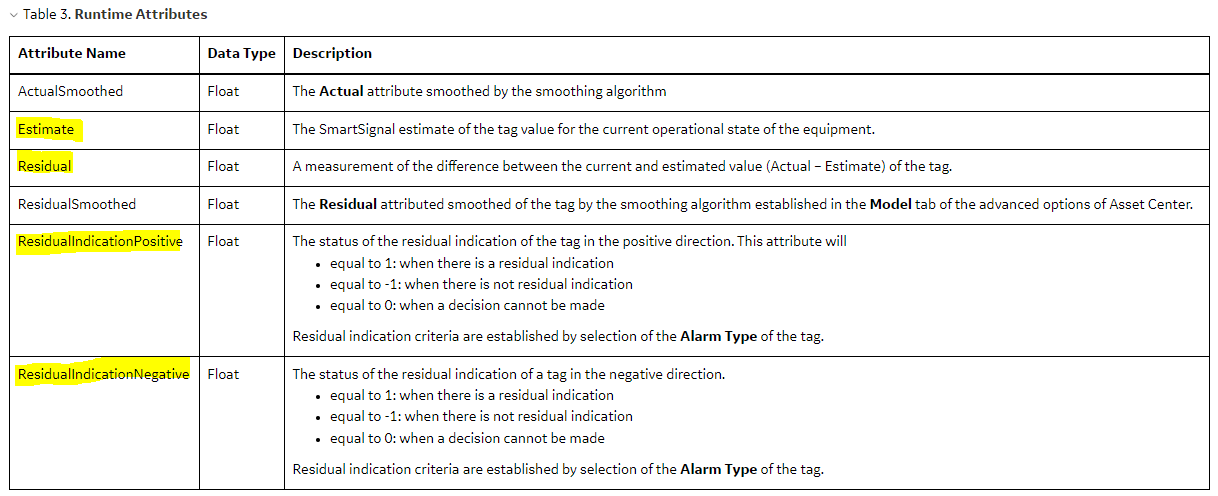

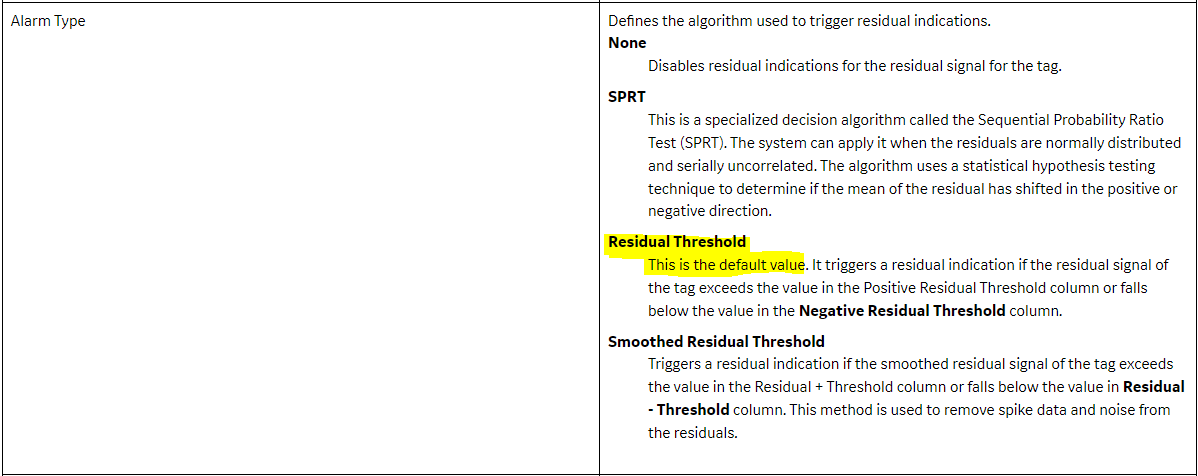

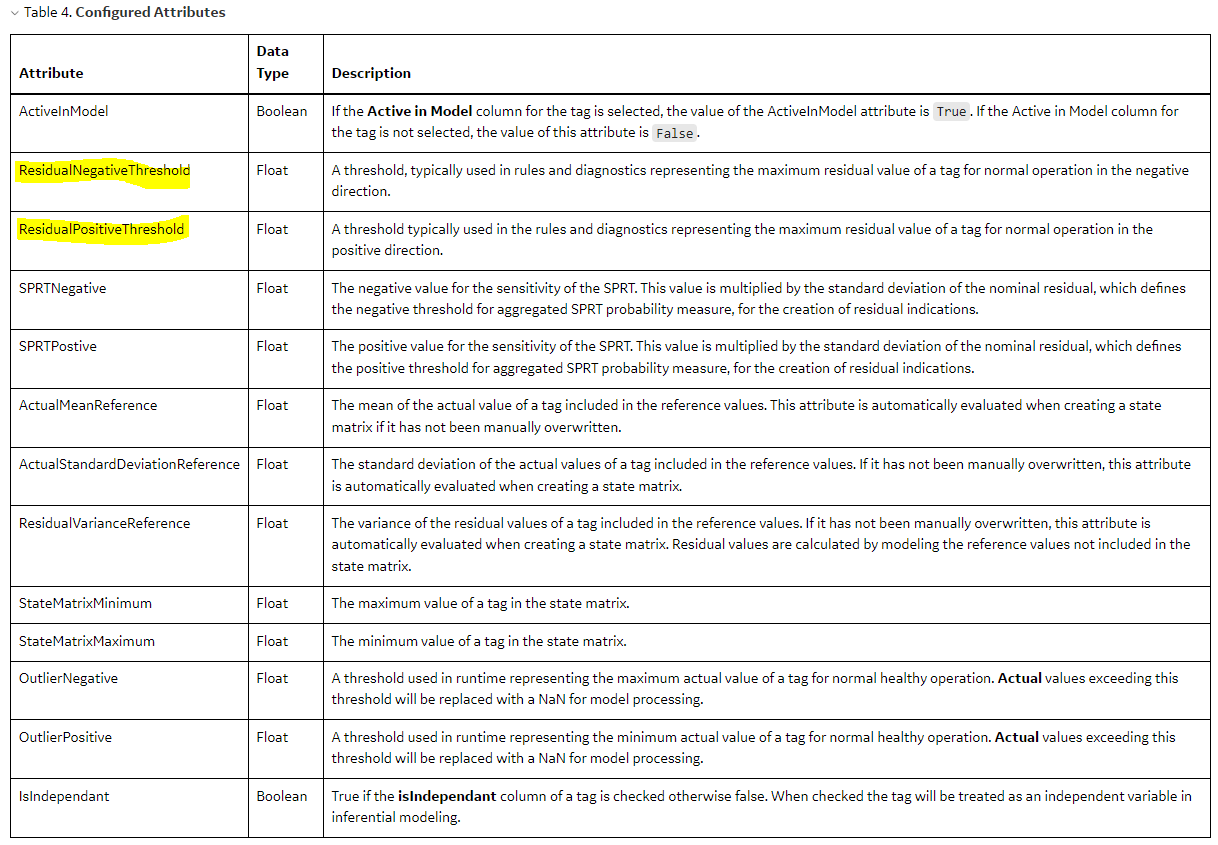

Analytic tag attributes needed for `ST Journal Bearing 1 - Cooling Loss`.

Runtime Attributes:
- `Actual`

Configured Attributes:
- `ActualHigh`
- `ActualLow`

Model tag attributes needed for `ST Journal Bearing 1 - Cooling Loss`.

Runtime Attributes:
- `Estimate`
- `Residual`
- `ResidualIndicationPositive`
- `ResidualIndicationNegative`

Configured Attributes:
- `ResidualNegativeThreshold`
- `ResidualPositiveThreshold`

> We choose `AlarmType` by default is `Residual Threshold`

We need to define all of the **Configured Attributes**.

## Define Configured Attributes

In [19]:
# analytic tag
analytic_configured = threshold.copy()
# rename columns name
analytic_configured = analytic_configured.rename(columns={'Actual (Low)':'ActualLow',
                                                          'Actual (High)':'ActualHigh'})
analytic_configured

,ActualLow,ActualHigh
Generator Gross Capacity,433.969025,610.248900
Turbine Lube Oil Cooler Outlet Temperature,41.625633,47.335740
Turbine Bearing #01 Metal Temperature,75.298727,92.167030
Turbine.Bearing 1 Metal Temperature,80.187670,87.590470
Turbine.Bearing Oil Pressure,1.467023,1.512295
Turbine.Bearing 1 Drain Oil Temperature,47.408993,52.000000


In [20]:
analytic_configured['ActualHigh'] - analytic_configured['ActualLow']

Generator Gross Capacity                      176.279875
Turbine Lube Oil Cooler Outlet Temperature      5.710107
Turbine Bearing #01 Metal Temperature          16.868303
Turbine.Bearing 1 Metal Temperature             7.402800
Turbine.Bearing Oil Pressure                    0.045272
Turbine.Bearing 1 Drain Oil Temperature         4.591007
dtype: float64

In [21]:
# model tag

# use the difference between ActualHigh and ActualLow
values = [[-176.279875, 176.279875],
          [-5.710107, 5.710107],
          [-16.868303, 16.868303],
          [-7.402800, 7.402800],
          [-0.045272, 0.045272],
          [-4.591007, 4.591007]]
model_configured = pd.DataFrame(data=values,
                                index=analytic_configured.index,
                                columns=['ResidualNegativeThreshold','ResidualPositiveThreshold'])
model_configured

,ResidualNegativeThreshold,ResidualPositiveThreshold
Generator Gross Capacity,-176.279875,176.279875
Turbine Lube Oil Cooler Outlet Temperature,-5.710107,5.710107
Turbine Bearing #01 Metal Temperature,-16.868303,16.868303
Turbine.Bearing 1 Metal Temperature,-7.402800,7.402800
Turbine.Bearing Oil Pressure,-0.045272,0.045272
Turbine.Bearing 1 Drain Oil Temperature,-4.591007,4.591007


## Process Runtime Attributes

In [22]:
N_TAG = 6

def estimate_sensors(actual, state_matrix, analytic_conf):
    """Estimate smart signal
    actual: sensor values
    state_matrix: state matrix
    analytic_conf: object analytic configured attributes
    """

    temp = []
    th = analytic_conf.values
    # CHECK IF WE NEED TO UPDATE THE STATE MATRIX
    for i in range(N_TAG):
        act = actual[i] 
        th_low = th[i][0]
        th_high = th[i][1]
        if act > th_low and act < th_high:
            temp.append(act)
        else:
            break
    # update state_matrix if all of the sensors are normal
    if len(temp) == N_TAG:  # 6 sensors/tags
        temp = np.array(temp).reshape(-1,1)
        state_matrix = np.insert(state_matrix, [400], temp, axis=1)
        state_matrix = state_matrix[:,1:]
    
    # CREATE DYNAMIC MATRIX
    dm, w = create_dynamic_matrix(state_matrix, actual)

    # ESTIMATE DATA t+1
    x_est = np.array(vbm(dm, w))

    return x_est, state_matrix

def calculate_residual(actual, estimate):
    return actual - estimate

def residual_indication_negative_flag(residual, residual_negative_threshold):
    if residual < residual_negative_threshold:
        return 1
    elif residual > residual_negative_threshold:
        return -1
    else:
        return 0

def residual_indication_positive_flag(residual, residual_positive_threshold):
    if residual > residual_positive_threshold:
        return 1
    elif residual < residual_positive_threshold:
        return -1
    else:
        return 0    

In [24]:
big_matrix = data[cols].values.T
big_matrix.shape

(6, 132479)

In [25]:
%%time
# Estimate t+1 sensor data
actuals = []
estimates = []
residuals = []
residual_ind_pos = []
residual_ind_neg = []
state_matrix = state_matrix

for i in range(big_matrix.shape[1]):
    current_actual = big_matrix[:, i]

    # calculate estimate value
    x_est, state_matrix = estimate_sensors(actual=current_actual,
                                           state_matrix=state_matrix,
                                           analytic_conf=analytic_configured)
    
    # calculate residual
    residual = calculate_residual(current_actual, x_est)

    # residual threshold
    model_conf = model_configured.values
    resid_ind_pos = []
    resid_ind_neg = []

    for j in range(N_TAG):
        residual_positive_th = model_conf[j][1]
        residual_negative_th = model_conf[j][0]

        resid_pos = residual_indication_positive_flag(residual[j], residual_positive_th)
        resid_neg = residual_indication_negative_flag(residual[j], residual_negative_th)
        
        resid_ind_pos.append(resid_pos)
        resid_ind_neg.append(resid_neg)
        
    # append to list
    actuals.append(current_actual)
    estimates.append(x_est)
    residuals.append(residual)
    residual_ind_pos.append(resid_ind_pos)
    residual_ind_neg.append(resid_ind_neg)
    
# convert to numpy array
actuals = np.array(actuals)
estimates = np.array(estimates)
residuals = np.array(residuals)
residual_ind_pos = np.array(residual_ind_pos)
residual_ind_neg = np.array(residual_ind_neg)

CPU times: user 33min 33s, sys: 2min 9s, total: 35min 43s
Wall time: 33min 35s


In [26]:
# create data frame
df_actual = pd.DataFrame(actuals, columns=cols)
df_estimate = pd.DataFrame(estimates, columns=cols)
df_residual = pd.DataFrame(residuals, columns=cols)
df_resid_ind_pos = pd.DataFrame(residual_ind_pos, columns=cols)
df_resid_ind_neg = pd.DataFrame(residual_ind_neg, columns=cols)

# add date
df_actual['date'] = data['date']
df_estimate['date'] = data['date']
df_residual['date'] = data['date']
df_resid_ind_pos['date'] = data['date']
df_resid_ind_neg['date'] = data['date']

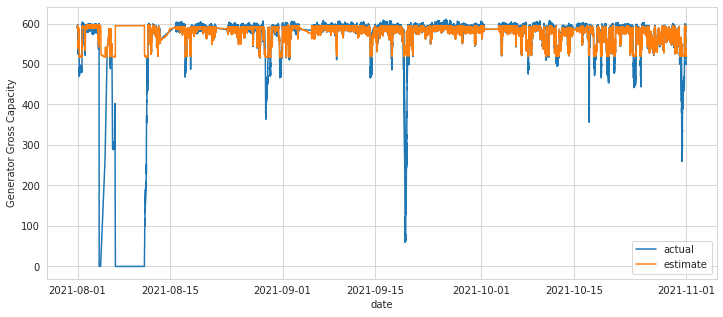

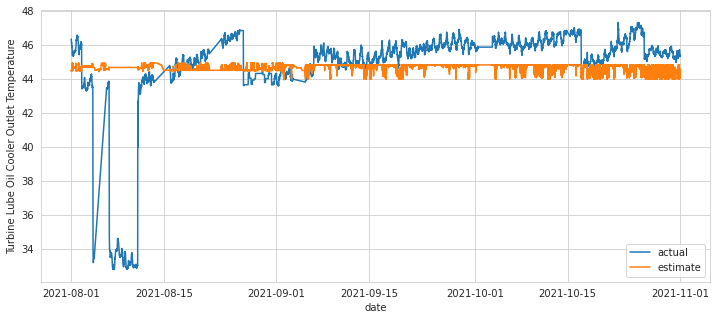

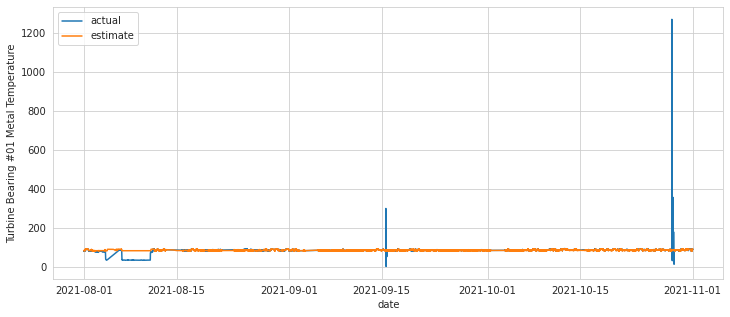

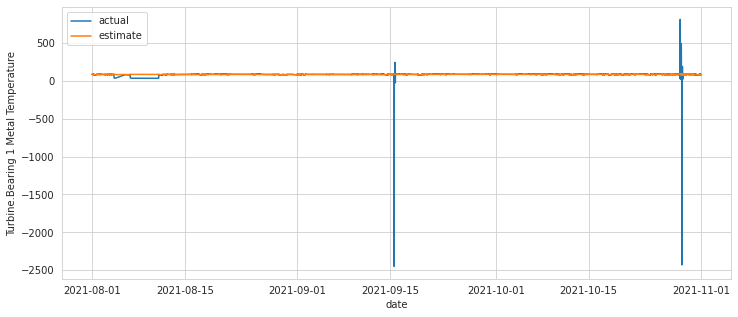

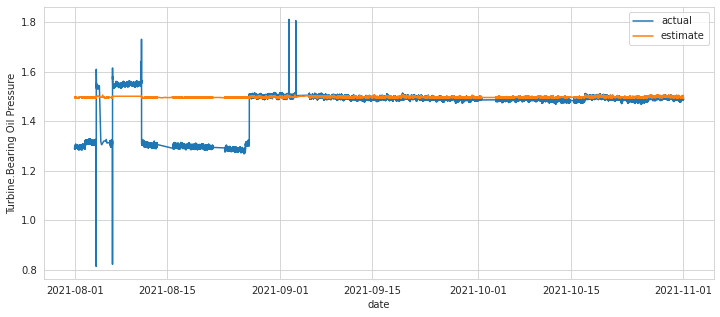

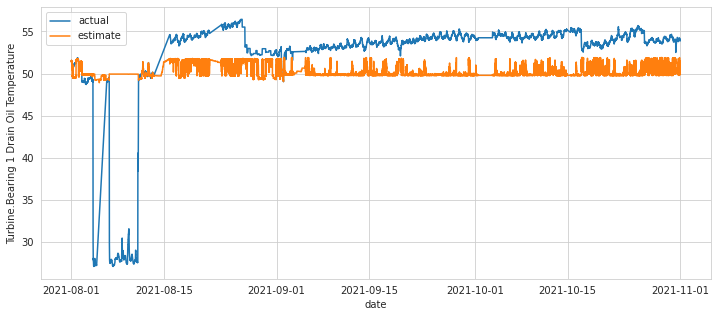

In [27]:
# plot actual and estimate
for i,col in enumerate(cols):
    plt.figure(figsize=(12,5))
    sns.lineplot(data=df_actual, x="date", y=col)
    sns.lineplot(data=df_estimate, x="date", y=col)
    plt.legend(['actual','estimate'])
    plt.show();

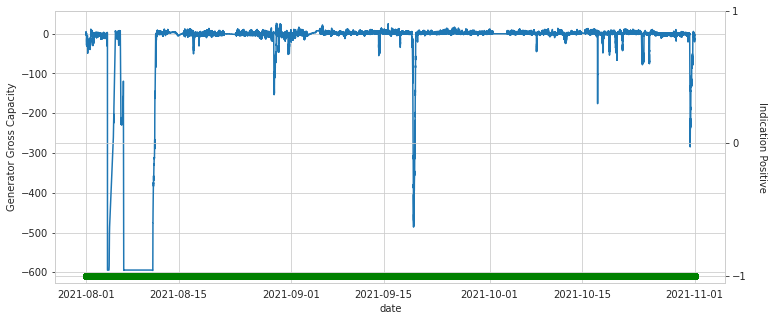

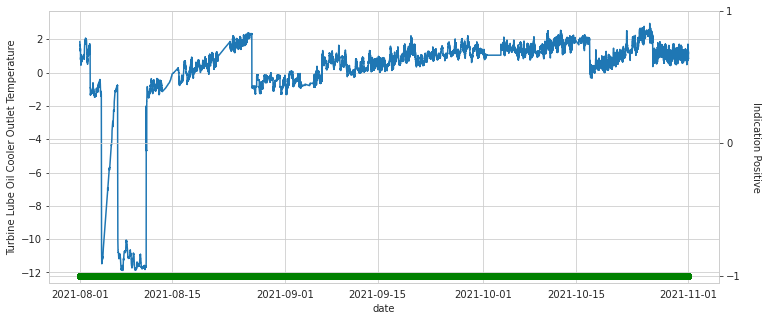

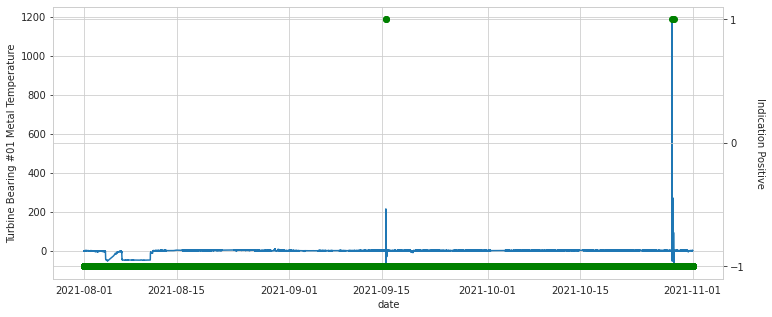

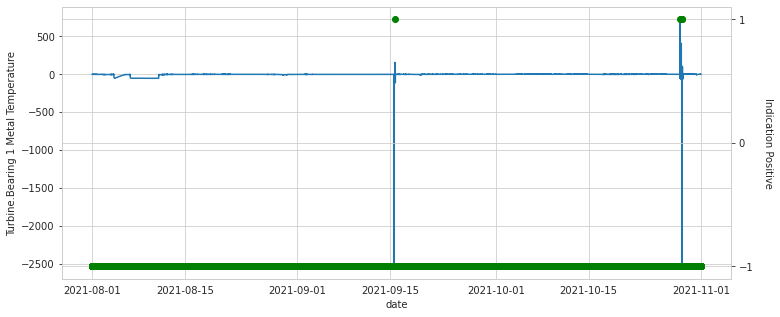

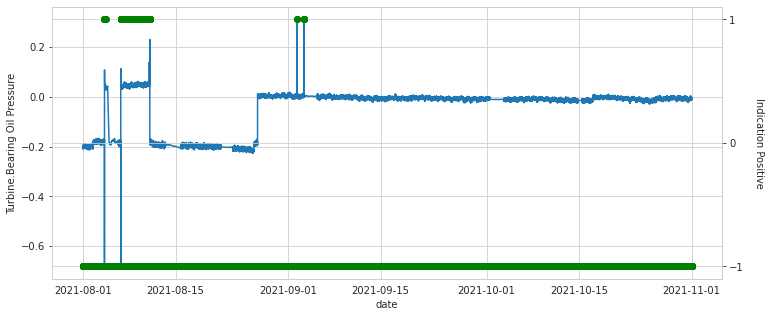

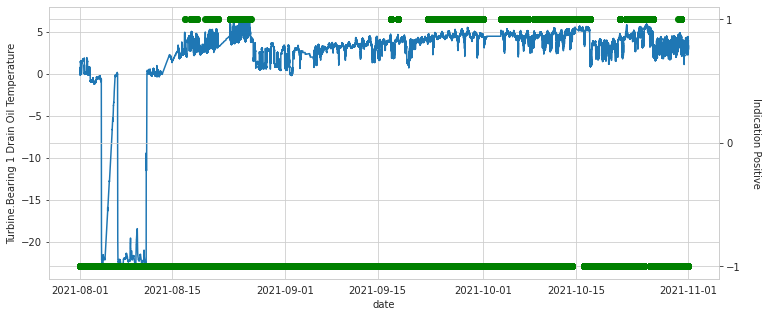

In [28]:
# plot residual and residual indication positive
for i,col in enumerate(cols):
    fig, ax1 = plt.subplots(figsize=(12,5))
    ax2 = ax1.twinx()

    ax1.plot(df_residual['date'], df_residual[col])
    ax1.set_ylabel(col)
    ax1.set_xlabel('date')

    ax2.scatter(df_resid_ind_pos['date'], df_resid_ind_pos[col], color='green')
    ax2.set_ylabel('Indication Positive', rotation=270, labelpad=20)
    ax2.set_yticks(range(-1,2))

    plt.show();

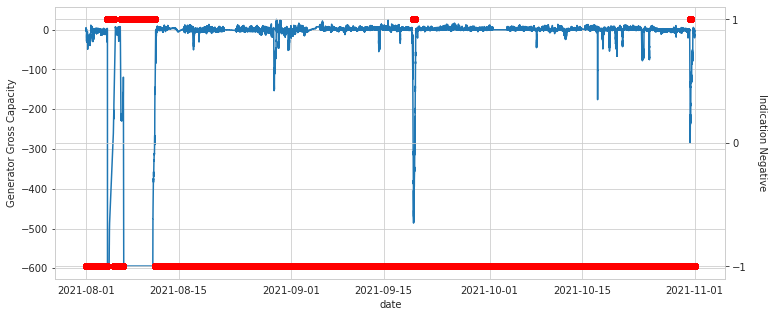

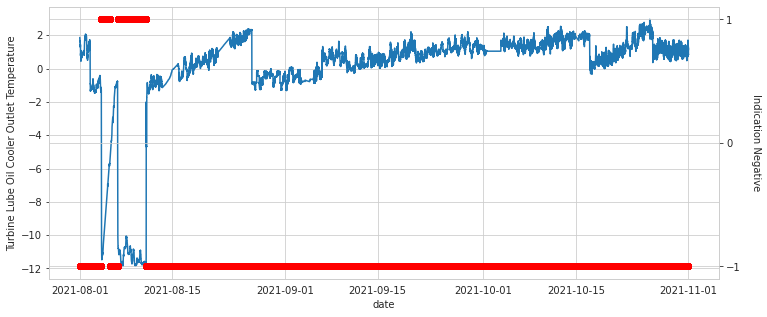

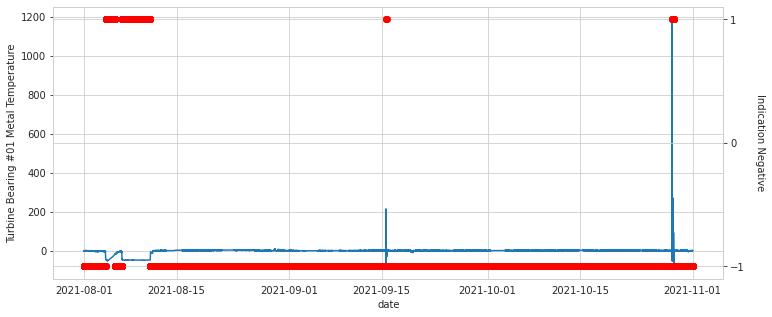

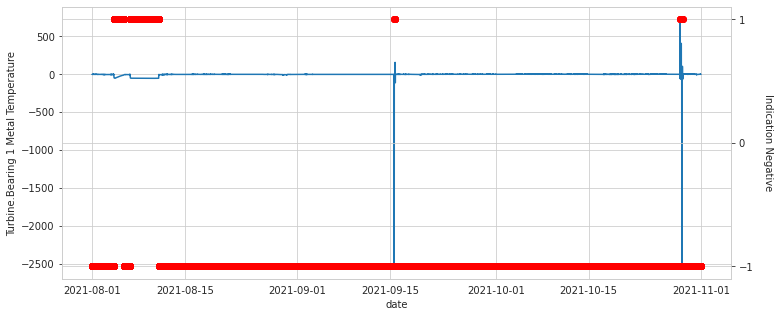

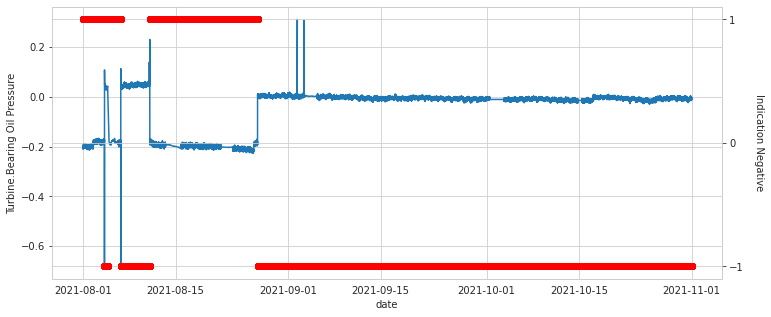

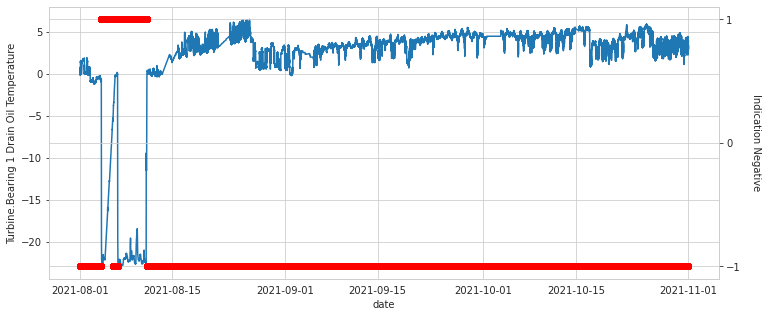

In [29]:
# plot residual and residual indication negative
for i,col in enumerate(cols):
    fig, ax1 = plt.subplots(figsize=(12,5))
    ax2 = ax1.twinx()

    ax1.plot(df_residual['date'], df_residual[col])
    ax1.set_ylabel(col)
    ax1.set_xlabel('date')

    ax2.scatter(df_resid_ind_neg['date'], df_resid_ind_neg[col], color='red')
    ax2.set_ylabel('Indication Negative', rotation=270, labelpad=20)
    ax2.set_yticks(range(-1,2))

    plt.show();

## Rule Assignment

https://www.ge.com/digital/documentation/predix-apm/latest/r_apm_smartsignal_exp_syn_logical_functions.html

Function: `WindowRatio()`
- Description: This function looks at a window of data and compares it to a threshold. If the number of true comparisons is greater than or equal to the `trueSize` than `windowRatio` will return `true` otherwise it will return `false`.
    - Integer `trueSize`, The trueSize specifies the number of true comparison must be found in the window (specified in values) for windowRatio to return `True`. When a `NaN` present in values the `TrueSize` is divided by the window to create a ratio (or percentage) for which 
    - List values, A list of tag values to be compared to the threshold. The window size is specified by the size of the list. E.g. `Tag.Actual(20)` is a window of 20 
    - String comparisonOperator,  Specifies how to compare the values to the threshold. Valid options are: `=`, `>`, `<`, `>=`, `<=`, `!=`. The operator must be in quotes, `“=”`
    - Float threshold, A threshold that the values will be compared to
    - Integer requiredGoodSize, The required number of numeric values. If the number of numeric (non `NaN`s) in values is less than this value `windowRatio` will return `false`. Typically `requiredGoodSize` is about `one half the window size.`
- Example: `WindowRatio(17, Tag.ResidualIndicationPositive(18), ”=”, 1, 9)`

---

Function: `isStep()`
- Description: This function returns true if there is a step change in values provided.

    `Olympic smoothing` will be performed on the values provided (excluding the most recent observation) to obtain the `averageValue` previous to the most recent observation. The two most recent observations will be compared to the `averageValue` evaluating the difference. A step change is determined if for both comparisons:

    ```value – averageValue > |stepUpThreshold| or value – averageValue < -|stepDownThreshold|```

    - `values`: A set of tag history containing at least 4 observations E.g. `Tag.Actual(7)`
    - `stepUpThreshold`: Required magnitude of the step change in the positive direction. Step up can be ignored by specifying a stepUpThreshold of NaN()
    - `stepDownThreshold`: Required magnitude of the step change in the negative direction. Step down can be ignored by specifying a stepUpThreshold of NaN()
- Example: `isStep(Tag.Actual(7), Tag.StepHigh, Tag.StepLow)`

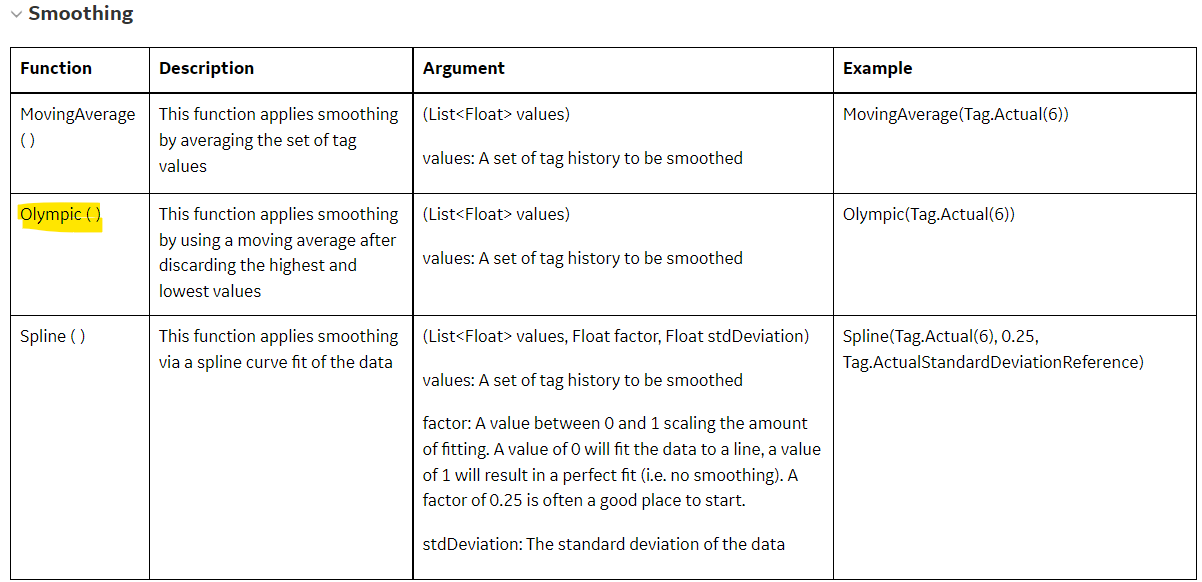

In [30]:
actual_df = df_actual.copy().set_index('date')
estimate_df = df_estimate.copy().set_index('date')
residual_df = df_residual.copy().set_index('date')
resid_indpos_df = df_resid_ind_pos.copy().set_index('date')
resid_indneg_df = df_resid_ind_neg.copy().set_index('date')

In [31]:
from datetime import timedelta

class Tag(object):

    def __init__(self, name, date):
        self.name = name
        self.date = date
        self.actual = []
        self.residual = []
        self.residual_indication_positive = []
        self.residual_indication_negative = []
        self.residual_positive_threshold = self.get_residual_positive_threshold()
        self.residual_negative_threshold = self.get_residual_negative_threshold()
    
    def Actual(self, n=1):
        start_date = self.get_start_date(self.date, n)
        self.actual = actual_df.loc[start_date:self.date][self.name]
        return self.actual.values
    
    def Residual(self, n=1):
        start_date = self.get_start_date(self.date, n)
        self.residual = residual_df.loc[start_date:self.date][self.name]
        return self.residual.values
    
    def ResidualIndicationPositive(self, n=1):
        start_date = self.get_start_date(self.date, n)
        self.residual_indication_positive = resid_indpos_df.loc[start_date:self.date][self.name]
        return self.residual_indication_positive.values

    def ResidualIndicationNegative(self, n=1):
        start_date = self.get_start_date(self.date, n)
        self.residual_indication_negative = resid_indneg_df.loc[start_date:self.date][self.name]
        return self.residual_indication_negative.values
    
    def ResidualPositiveThreshold(self):
        return self.residual_positive_threshold

    def ResidualNegativeThreshold(self):
        return self.residual_negative_threshold

    def get_start_date(self, date, n):
        return  pd.to_datetime(date) - timedelta(minutes=n-1)

    def get_residual_positive_threshold(self):
        return model_configured.loc[self.name]['ResidualPositiveThreshold']

    def get_residual_negative_threshold(self):
        return model_configured.loc[self.name]['ResidualNegativeThreshold']

In [32]:
# example
tag = Tag(name="Generator Gross Capacity",
          date='2021-08-01 00:07:00')
tag.ResidualIndicationPositive(18)

array([-1, -1, -1, -1, -1, -1, -1, -1])

In [33]:
import operator

comp_operator = {
    '=': operator.eq,
    '>': operator.gt,
    '<': operator.lt,
    '>=': operator.ge,
    '<=': operator.le,
    '!=': operator.ne
}

def window_ratio(true_size, values, comparison, threshold, required_size):
    # check required good size
    if np.count_nonzero(~np.isnan(values)) < required_size: return False
    # compare values with threshold
    comp = [True if comp_operator.get(comparison)(v,threshold) else False for v in values]
    # check the number of true comparisons and compare them with true_size
    return True if np.sum(comp) >= true_size else False

def moving_average(a, n=2) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def smoothing(values, fn="olympic"):
    if fn == "olympic":
        # delete min and max value
        values = np.delete(values, values.argmin())
        values = np.delete(values, values.argmax())
        # moving average with window = 2 
        values = moving_average(values, n=2)
        return values

def is_step(values, step_up_threshold, step_down_threshold):
    # check values
    if len(values) < 4: return "You need at least 4 observations!"
    
    # exclude the most recent values
    history = values[:-1]
    history = smoothing(history)
    avg_value = np.mean(history)

    # get the two most recent observation
    obs = values[-2:]

    # check NaN
    if step_up_threshold == "NaN":
        rule_val1 = obs[0] - avg_value < -abs(step_down_threshold)
        rule_val2 = obs[1] - avg_value < -abs(step_down_threshold)
    elif step_down_threshold == "NaN":
        rule_val1 = obs[0] - avg_value > abs(step_up_threshold)
        rule_val2 = obs[1] - avg_value > abs(step_up_threshold)
    else:
        rule_val1 = (obs[0] - avg_value > abs(step_up_threshold)) or (obs[0] - avg_value < -abs(step_down_threshold))
        rule_val2 = (obs[1] - avg_value > abs(step_up_threshold)) or (obs[1] - avg_value < -abs(step_down_threshold))

    return rule_val1 and rule_val2

### High (H)

**Expressions:**

```
(WindowRatio(16, Tag.ResidualIndicationPositive(18), "=", 1, 9)) And 
(Tag.Residual >= Tag.ResidualPositiveThreshold)
```

In [34]:
def high(tag) -> bool:
    rule1 = window_ratio(16, tag.ResidualIndicationPositive(18), "=", 1, 9)
    rule2 = tag.Residual(1) >= tag.ResidualPositiveThreshold()
    return rule1 and rule2

In [35]:
tag = Tag(name="Generator Gross Capacity", date="2021-08-01 00:07:00")

high(tag)

False

### Very High (VH)

Expressions:
```
(WindowRatio(8, Tag.ResidualIndicationPositive(9), "=", 1, 6)) And 
(WindowRatio(6, Tag.Residual(9), ">=", (2.0* TagResidualPositiveThreshold), 6)) and
(Tag.Residual>=(2.0* Tag.ResidualPositiveThreshold))
```

In [36]:
def very_high(tag) -> bool:
    rule1 = window_ratio(8, tag.ResidualIndicationPositive(9), "=", 1, 6)
    rule2 = window_ratio(6, tag.Residual(9), ">=", (2.*tag.ResidualPositiveThreshold()),6)
    rule3 = tag.Residual(1) >= (2.*tag.ResidualPositiveThreshold())
    return rule1 and rule2 and rule3

In [37]:
tag = Tag(name="Generator Gross Capacity", date="2021-08-01 00:07:00")

very_high(tag)

False

### Step High (SH)

**Expressions:**
```
IsStep(Tag.Actual(7), 2.5* Tag.ResidualPositiveThreshold, NaN()) And
(Tag.Residual>(1.5* Tag.ResidualPositiveThreshold))
```

In [38]:
def step_high(tag) -> bool:
    rule1 = is_step(values=tag.Actual(7), 
                    step_up_threshold=2.5*tag.ResidualPositiveThreshold(),
                    step_down_threshold="NaN")
    rule2 = tag.Residual(1) > 1.5*tag.ResidualPositiveThreshold()
    return rule1 and rule2

In [39]:
tag = Tag(name="Generator Gross Capacity", date="2021-08-01 00:07:00")

step_high(tag)

False

### Step Very High (SVH)

**Expressions:**
```
IsStep(Tag.Actual(7), 3.0*Tag.ResidualPositiveThreshold, NaN()) and 
(Tag.Residual > (2.0*Tag.ResidualPositiveThreshold)) and 
Tag.ResidualIndicationPositive=1
```

In [40]:
def step_very_high(tag) -> bool:
    rule1 = is_step(values=tag.Actual(7), 
                    step_up_threshold=3.*tag.ResidualPositiveThreshold(),
                    step_down_threshold="NaN")
    rule2 = tag.Residual(1) > 2.*tag.ResidualPositiveThreshold()
    rule3 = tag.ResidualIndicationPositive(1) == 1
    return rule1 and rule2 and rule3

In [41]:
tag = Tag(name="Generator Gross Capacity", date="2021-08-01 00:07:00")

step_very_high(tag)

False

### Variance (VAR)

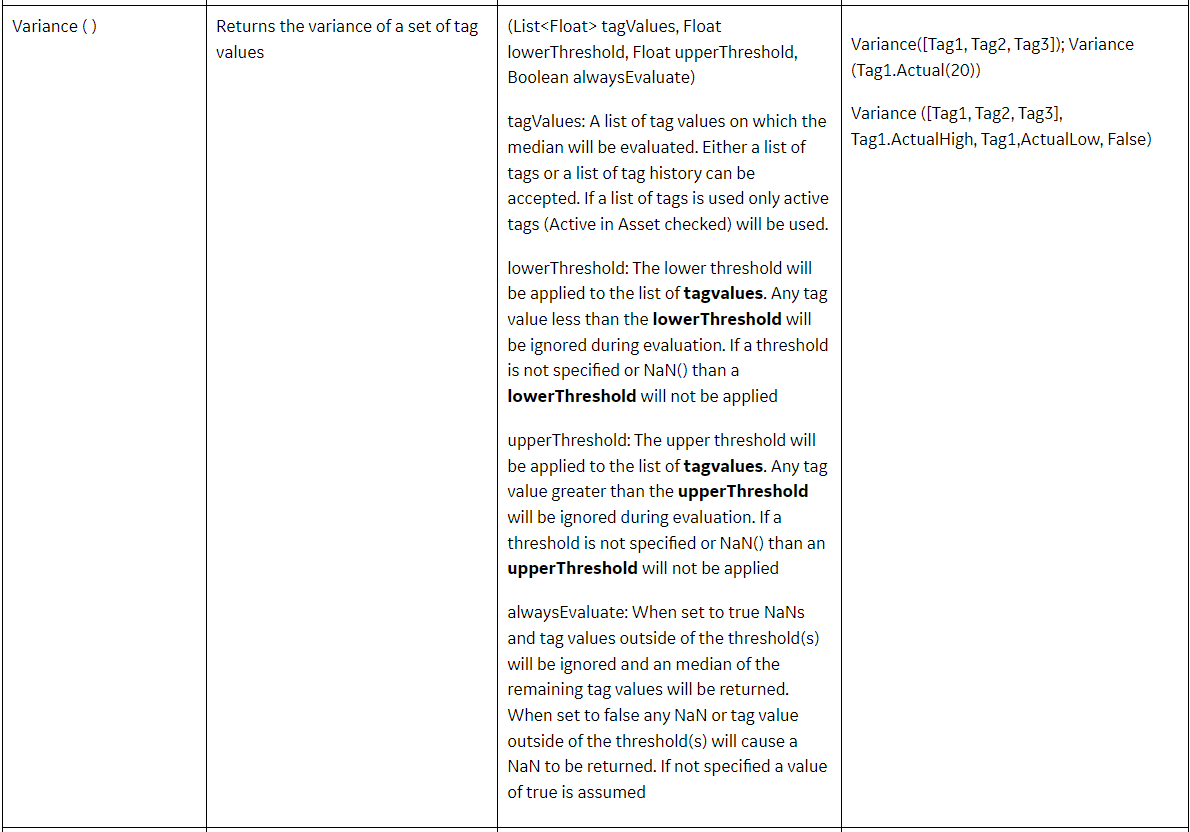

Expressions:
```
(Variance(Tag.Residual(18)) > (4*Minimum([abs(Tag.ResidualPositiveThreshold), abs(Tag.ResidualNegativeThreshold)])^2))
And 
WindowRatio(2, Tag.Residual(6),"">="",Minimum([abs(Tag.ResidualPositiveThreshold), abs(Tag.ResidualNegativeThreshold)]),4)
And 
WindowRatio(2,Tag.Residual(6),""<="",(-1)*Minimum([abs(Tag.ResidualPositiveThreshold), abs(Tag.ResidualNegativeThreshold)]),4)
```

In [42]:
def math_variance(values, lower_threshold="NaN", upper_threshold="NaN"):
    # variance with threshold not implemented yet
    return np.var(values)

def math_minimum(values, lower_threshold="NaN", upper_threshold="NaN"):
    # minimum with threshold not implemented yet
    return np.min(values)

def variance(tag) -> bool:
    rule1 = math_variance(tag.Residual(18)) > (4*math_minimum([abs(tag.ResidualPositiveThreshold()), abs(tag.ResidualPositiveThreshold())])**2)
    rule2 = window_ratio(true_size=2, 
                         values=tag.Residual(6), 
                         comparison=">=", 
                         threshold=math_minimum([abs(tag.ResidualPositiveThreshold()), abs(tag.ResidualPositiveThreshold())]),
                         required_size=4)
    rule3 = window_ratio(true_size=2, 
                         values=tag.Residual(6), 
                         comparison="<=", 
                         threshold=-1*math_minimum([abs(tag.ResidualPositiveThreshold()), abs(tag.ResidualPositiveThreshold())]),
                         required_size=4)
    return rule1 and rule2 and rule3

In [43]:
tag = Tag(name="Generator Gross Capacity", date="2021-08-01 00:07:00")

variance(tag)

False

## Model Diagnostic

**Modified Expressions:**

```
if
    (ModelIndications(MECHANICAL,[SVH,SH,VH],[Turbine.Bearing 1 Drain Oil Temperature])>=1.0
    and
    ModelIndications(MECHANICAL,[SVH,SH,VH],[Turbine Bearing #01 Metal Temperature, Turbine.Bearing 1 Metal Temperature])>=1.0)
then 
    Priority(2)
else if
    (ModelIndications(MECHANICAL,[SVH,SH,VH],[Turbine.Bearing 1 Drain Oil Temperature])>=1.0
    or 
        (ModelIndications(MECHANICAL,[VAR,H],[Turbine.Bearing 1 Drain Oil Temperature])>=1.0
        and
        ModelIndications(MECHANICAL,[VAR,H],[Turbine Bearing #01 Metal Temperature, Turbine.Bearing 1 Metal Temperature])>=1.0))
then 
    Priority(3)
else if
    (ModelIndications(MECHANICAL,[VAR,H],[Turbine.Bearing 1 Drain Oil Temperature])>=1.0)
then 
    Priority(4)
else
    IsAssociated(MECHANICAL,[GROSS_LOAD,AMBIENT_TEMP,LUBE_OIL_COOLER_OIL_OUTLET_TEMP, LUBE_OIL_COOLER_OIL_OUTLET_PRESS])
```

Function: `ModelIndications()`
- Description: Returns a count of the number of model tag advisory indications on a set of model tags.

    An advisory indication exists when the conditional logic of the rule evaluates to true for the model tag. Using the ModelIndications() function will assign each of the model rules to each of the model tags. When the conditional logic is met the advisory indication chart marker will be displayed in Sentinel.
    - `model`: A name of a model in the asset blueprint. Only one model may be specified. All modelTagRules will counted from this model only

    - `modelTagRules`: A list of model blueprint tag rules (mnemonics). Model blueprint tag rules are specified on the Rules tab of Blueprint Center (in green)

    - `assetTags`: A list of asset blueprint tags aliases. Asset blueprint tags are specified on the Tags sub tab of the Asset Blueprints tab. If the asset blueprint tag alias is not assigned to the model then model tag advisory indications cannot be created
- Example: `If (ModelIndications(Mechanical,[H],[Tag1, Tag2]) >=2 ) then …`

In [44]:
# tag rules dictionary
rules = {
    'H': high,
    'VH': very_high,
    'SH': step_high,
    'SVH': step_very_high,
    'VAR': variance,
}

def pair_rule_and_asset(tag_rules, asset_tags):
    result = []
    for rule in tag_rules:
        for asset in asset_tags:
            result.append((rule, asset))
    return result

def model_indications(model, tag_rules, asset_tags, date):
    indication = []

    for rule, asset in pair_rule_and_asset(tag_rules, asset_tags):
        # initialize tag
        tag = Tag(name=asset, date=date)
        # assign rule
        ind = rules.get(rule)(tag)
        indication.append(ind)

    return np.sum(indication)

In [45]:
# example
tag_rules = ['SVH', 'SH', 'VH']
asset_tags = ['Turbine.Bearing 1 Drain Oil Temperature']

model_indications('Mechanical', tag_rules, asset_tags, "2021-08-01 00:07:00")

0

Function: `IsAssociated ( )`
- Description: Used to complete diagnostic logic as well as associated model tags with diagnostic logic

    Associated tags will be displayed in the diagnostic advisory folder in Sentinel’s asset explorer. Any model tag used in Modelindications() is automatically associated with the diagnostic
    - `model`: A name of a model in the asset blueprint. Only one model may be specified
    - `assetTags`: A list of asset tags to associated with the diagnostic. If the asset blueprint tag alias is not assigned to model no association will be created
- Example: `If (ModelIndications(Mechanical,[H],[Tag1, Tag2]) >=2 ) then Priority(5) else IsAssociated(Mechanical,[Tag3])`

In [46]:
# ???
def is_associated(model, asset_tags):
    return 0

**Modified Expressions:**

```
if
    (ModelIndications(MECHANICAL,[SVH,SH,VH],[Turbine.Bearing 1 Drain Oil Temperature])>=1.0
    and
    ModelIndications(MECHANICAL,[SVH,SH,VH],[Turbine Bearing #01 Metal Temperature, Turbine.Bearing 1 Metal Temperature])>=1.0)
then 
    Priority(2)
else if
    (ModelIndications(MECHANICAL,[SVH,SH,VH],[Turbine.Bearing 1 Drain Oil Temperature])>=1.0
    or 
        (ModelIndications(MECHANICAL,[VAR,H],[Turbine.Bearing 1 Drain Oil Temperature])>=1.0
        and
        ModelIndications(MECHANICAL,[VAR,H],[Turbine Bearing #01 Metal Temperature, Turbine.Bearing 1 Metal Temperature])>=1.0))
then 
    Priority(3)
else if
    (ModelIndications(MECHANICAL,[VAR,H],[Turbine.Bearing 1 Drain Oil Temperature])>=1.0)
then 
    Priority(4)
else
    IsAssociated(MECHANICAL,[GROSS_LOAD,AMBIENT_TEMP,LUBE_OIL_COOLER_OIL_OUTLET_TEMP, LUBE_OIL_COOLER_OIL_OUTLET_PRESS])
```

In [47]:
def diagnostic(date):
    if model_indications('MECHANICAL', ['SVH','SH','VH'], ['Turbine.Bearing 1 Drain Oil Temperature'], date) >= 1. and \
       model_indications('MECHANICAL', ['SVH','SH','VH'], ['Turbine Bearing #01 Metal Temperature','Turbine.Bearing 1 Metal Temperature'], date) >= 1.:
        return 2
    elif model_indications('MECHANICAL', ['SVH','SH','VH'], ['Turbine.Bearing 1 Drain Oil Temperature'], date) >= 1. or \
            (model_indications('MECHANICAL', ['VAR','H'], ['Turbine.Bearing 1 Drain Oil Temperature'], date) >= 1. and \
             model_indications('MECHANICAL', ['VAR','H'], ['Turbine Bearing #01 Metal Temperature','Turbine.Bearing 1 Metal Temperature'], date) >= 1.):
        return 3
    elif model_indications('MECHANICAL', ['VAR','H'], ['Turbine.Bearing 1 Drain Oil Temperature'], date) >= 1.:
        return 4
    else:
        return is_associated('MECHANICAL', ['others'])

In [48]:
# example
date = "2021-08-01 00:10:00"
diagnostic(date)

0

In [49]:
%%time
# loop over time on 'date'
full_date = df_actual['date']
priorities = []

for date in full_date:
    priority = diagnostic(date)
    priorities.append(priority)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CPU times: user 25min 42s, sys: 13.8 s, total: 25min 56s
Wall time: 25min 54s


In [50]:
np.unique(priorities), len(priorities)

(array([0, 4]), 132479)

In [76]:
# create dataframe for priority
df_priorities = pd.DataFrame(priorities, columns=['priority'])
df_priorities['date'] = data['date']

# remove data with priority = 0
df_priorities = df_priorities[df_priorities['priority'] != 0].reset_index(drop=True)
df_priorities['flag'] = 1

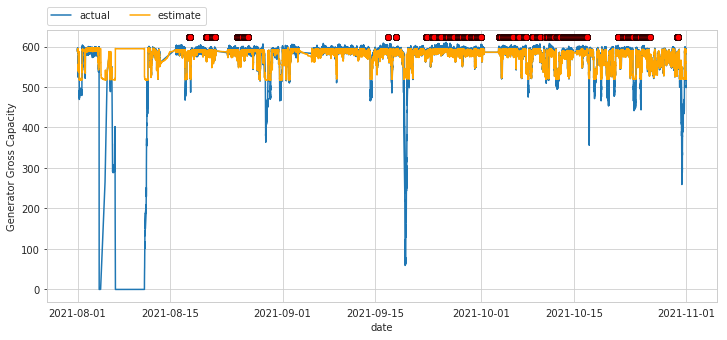

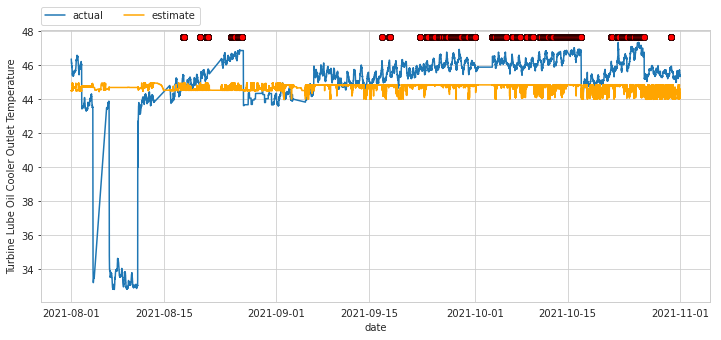

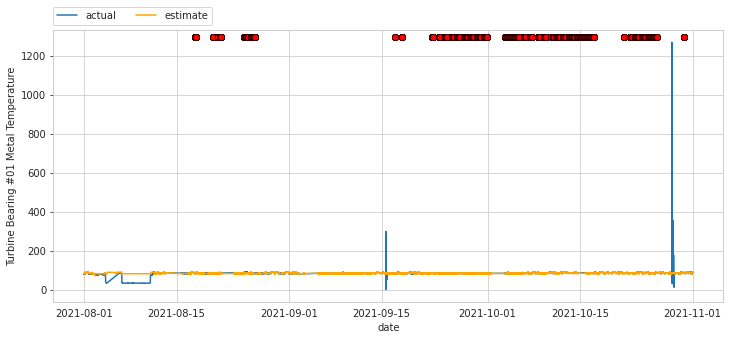

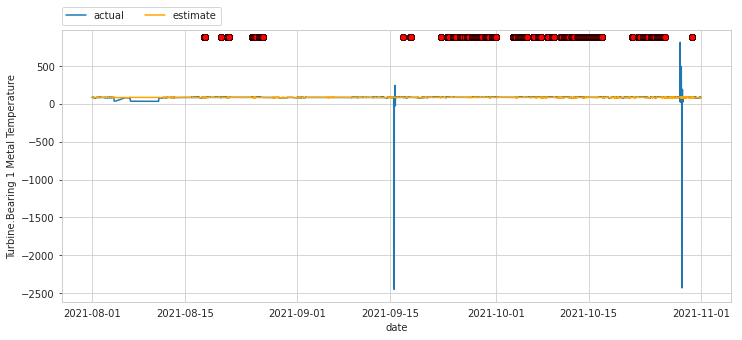

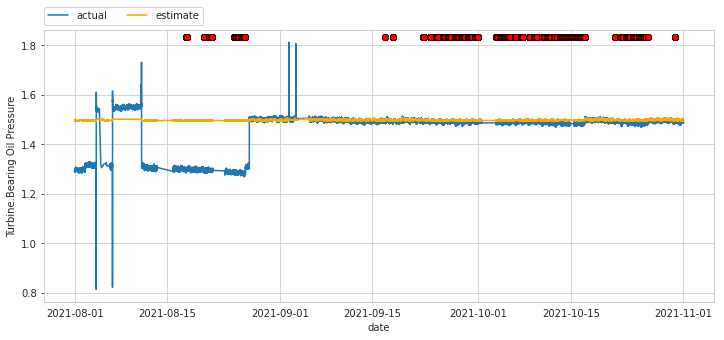

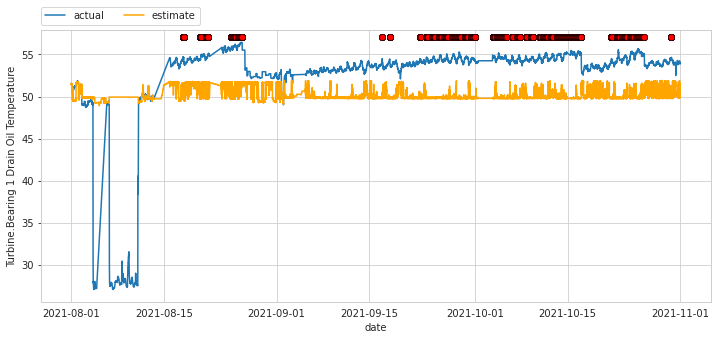

In [81]:
for i,col in enumerate(cols):
    fig, ax1 = plt.subplots(figsize=(12,5))
    ax2 = ax1.twinx()

    ax1.plot(df_actual['date'], df_actual[col])
    ax1.set_ylabel(col)
    ax1.set_xlabel('date')

    ax1.plot(df_actual['date'], df_estimate[col], color='orange')
    ax1.set_ylabel(col)
    ax1.set_xlabel('date')
    ax1.legend(['actual','estimate'], bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
               borderaxespad=0, ncol=3)

    ax2.scatter(df_priorities['date'], df_priorities['flag'], color='red', 
                s=40, edgecolors= "black", linewidth=0.5)
    ax2.set_ylabel('Priority', rotation=270, labelpad=20)
    ax2.set_yticks(range(-1,1))
    ax2.get_yaxis().set_visible(False)

    plt.show();